In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, LassoCV
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta
from IPython.display import display, Math
import re
from arch import arch_model
from arch.univariate import ZeroMean, GARCH, Normal
import pickle
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf

In [4]:
import preprocessing as preproc

In [5]:
def cfs_to_af(cfs_day):
    """
    Convert 'CFS‑days' to acre‑feet:

    acre‑ft = cfs_day / 1.9835
    """
    return cfs_day / 1.9835 


def af_to_m3(acft):
    """Convert acre‑feet to cubic metres (1 af = 1233.48 m³)."""
    return acft * 1233.48

def ft_to_m(ft):
    return ft / 3.281


def kcfs_to_m3hr(kcfs):
    """(1000 cfs = 1kcfs = 28.32 m³/s --> m3/hr """
    return kcfs * 28.32 * 3600


In [6]:
def replace_outliers(data, max_val=1e8):
    """Replace values outside [-max_val, max_val] with average of nearest valid neighbors"""
    arr = np.array(data, dtype=float)
    outlier_count = 0
    
    for i in range(len(arr)):
        if arr[i] > max_val or arr[i] < -max_val:
            outlier_count += 1
            # Find left neighbor
            left = None
            for j in range(i-1, -1, -1):
                if -max_val <= arr[j] <= max_val:
                    left = arr[j]
                    break
            
            # Find right neighbor  
            right = None
            for j in range(i+1, len(arr)):
                if -max_val <= arr[j] <= max_val:
                    right = arr[j]
                    break
            
            # Replace with average of neighbors
            if left is not None and right is not None:
                arr[i] = (left + right) / 2
            elif left is not None:
                arr[i] = left
            elif right is not None:
                arr[i] = right
            else:
                arr[i] = 0
    
    print(f"Found and replaced {outlier_count} outliers")
    return arr

In [11]:
def timeseries_to_matrix(df):
    df['Date Time'] = pd.to_datetime(df['Date Time'])
    
    # Remove Feb 29
    df_no_leap = df[~((df['Date Time'].dt.month == 2) & (df['Date Time'].dt.day == 29))].copy()
    
    # Use original dayofyear but shift after Feb 29 removal
    df_no_leap['Year'] = df_no_leap['Date Time'].dt.year
    df_no_leap['Month'] = df_no_leap['Date Time'].dt.month  
    df_no_leap['Day'] = df_no_leap['Date Time'].dt.day
    
    # Create day of year: Jan 1 = 1, Dec 31 = 365 (after removing Feb 29)
    df_no_leap['DayOfYear'] = df_no_leap['Date Time'].dt.dayofyear
    
    # Adjust for leap day removal: if after Feb 28, subtract 1 in leap years
    leap_years = df_no_leap['Year'] % 4 == 0
    after_feb28 = (df_no_leap['Month'] > 2)
    df_no_leap.loc[leap_years & after_feb28, 'DayOfYear'] -= 1
    
    matrix = df_no_leap.pivot_table(
        index='Year',
        columns='DayOfYear', 
        values='Daily Inflow',
        aggfunc='first'
    )
    
    return matrix

In [13]:
def clean_variable_name(feature):
    '''Clean up variable names for LaTeX display'''
    # Replace inflow_m3hr_ with y
    if feature.startswith('inflow_m3hr_'):
        clean_name = feature.replace('inflow_m3hr_', 'y')
    # Replace outflow_m3hr_ with x
    elif feature.startswith('outflow_m3hr_'):
        clean_name = feature.replace('outflow_m3hr_', 'x')
    else:
        clean_name = feature
    
    # Handle Lag_n pattern - convert to subscript t-n
    lag_pattern = r'Lag_(\d+)'
    if re.search(lag_pattern, clean_name):
        # Extract the lag number
        lag_match = re.search(lag_pattern, clean_name)
        lag_num = lag_match.group(1)
        # Replace Lag_n with _{t-n}
        clean_name = re.sub(lag_pattern, f'_{{t-{lag_num}}}', clean_name)
    
    # Escape remaining underscores for LaTeX
    #clean_name = clean_name.replace('_', '\\_')
    
    return clean_name

# Model Train Mode

In [19]:
framework = "DIU"
# framework = "DDU"

# Data Load

In [30]:
bon_path = "/Users/elizacohn/Desktop/cascaded-hydro/streamflow-data-raw/bonneville/"
tda_path = "/Users/elizacohn/Desktop/cascaded-hydro/streamflow-data-raw/dalles/"

## Seasonal Analysis

In [33]:
bon_daily = pd.read_csv(bon_path + "bon-daily-inflow-calc.csv")

In [35]:
daily_inflow_col = 'BON.Flow-In.Ave.~1Day.1Day.CBT-REV [kcfs]'
bon_daily = bon_daily.rename(columns={daily_inflow_col: "Daily Inflow"})

In [37]:
bon_daily.head()

,Date Time,Daily Inflow
0,31-Jul-1960 23:00,185.3
1,01-Aug-1960 23:00,170.9
2,02-Aug-1960 23:00,184.1
3,03-Aug-1960 23:00,168.9
4,04-Aug-1960 23:00,194.9


In [39]:
# Transform matrix in 365 x N years

inflow_matrix = timeseries_to_matrix(bon_daily)

print(f"Matrix shape: {inflow_matrix.shape}")
print(f"Years: {inflow_matrix.index.min()} to {inflow_matrix.index.max()}")
print(f"Days: {inflow_matrix.columns.min()} to {inflow_matrix.columns.max()}")


Matrix shape: (66, 365)
Years: 1960 to 2025
Days: 1 to 365


In [41]:
inflow_matrix.head()

DayOfYear,1,2,3,4,5,6,7,8,9,10,...,356,357,358,359,360,361,362,363,364,365
Year,,,,,,,,,,,,,,,,,,,,,
1960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,109.1,97.3,97.1,98.5,98.2,101.9,96.2,96.9,103.7,100.0
1961,106.7,98.2,97.4,98.2,99.3,124.2,110.8,122.4,134.8,123.7,...,110.4,110.8,113.2,107.4,95.1,97.8,95.9,97.9,94.0,94.2
1962,89.6,90.8,100.0,99.5,93.3,94.6,103.9,103.4,107.4,144.7,...,146.6,150.6,152.2,140.8,142.6,128.7,128.3,128.4,136.5,139.1
1963,127.2,130.0,140.1,139.9,137.5,142.4,128.0,128.0,135.4,133.0,...,94.6,96.5,93.3,95.3,97.9,101.2,93.4,98.4,97.5,99.1
1964,95.5,104.3,91.6,98.9,97.8,101.1,94.0,103.3,103.7,103.9,...,224.4,386.4,419.9,432.4,342.9,NaN,284.3,245.4,190.1,186.9


In [43]:
## Calculate daily averages

daily_averages = inflow_matrix.mean(axis=0, skipna=True)

# Create a single-row DataFrame for the averages
avg_row = pd.DataFrame([daily_averages], index=['Average'], columns=inflow_matrix.columns)

# Concatenate original matrix with average row
inflow_matrix_with_avg = pd.concat([inflow_matrix, avg_row], axis=0)

In [45]:
## Identify DoY with min and max flow

# Get the average row
daily_averages = avg_row.loc['Average']

# Find day with minimum average inflow
min_day = daily_averages.idxmin()
min_value = daily_averages.min()

# Find day with maximum average inflow  
max_day = daily_averages.idxmax()
max_value = daily_averages.max()

In [47]:
def day_to_date(day_of_year):
    # Create a date using pandas
    date = pd.to_datetime(f"2023-01-01") + pd.Timedelta(days=int(day_of_year) - 1)
    return date.strftime("%B %d")

# Now this should work
print(f"Minimum inflow day: Day {min_day} ({day_to_date(min_day)}) = {min_value:.2f} kcfs")
print(f"Maximum inflow day: Day {max_day} ({day_to_date(max_day)}) = {max_value:.2f} kcfs")

Minimum inflow day: Day 275 (October 02) = 104.72 kcfs
Maximum inflow day: Day 157 (June 06) = 329.75 kcfs


In [49]:
## Identify Seasons

dry_start = (min_day - 45 - 1) % 365 + 1  
dry_end = (min_day + 45 - 1) % 365 + 1
print(f"90-Day Dry season: Day {dry_start} ({day_to_date(dry_start)}) to Day {dry_end} ({day_to_date(dry_end)})")

wet_start = (max_day - 45 - 1) % 365 + 1
wet_end = (max_day + 45 - 1) % 365 + 1
print(f"90-Day Wet season: Day {wet_start} ({day_to_date(wet_start)}) to Day {wet_end} ({day_to_date(wet_end)})")

90-Day Dry season: Day 230 (August 18) to Day 320 (November 16)
90-Day Wet season: Day 112 (April 22) to Day 202 (July 21)


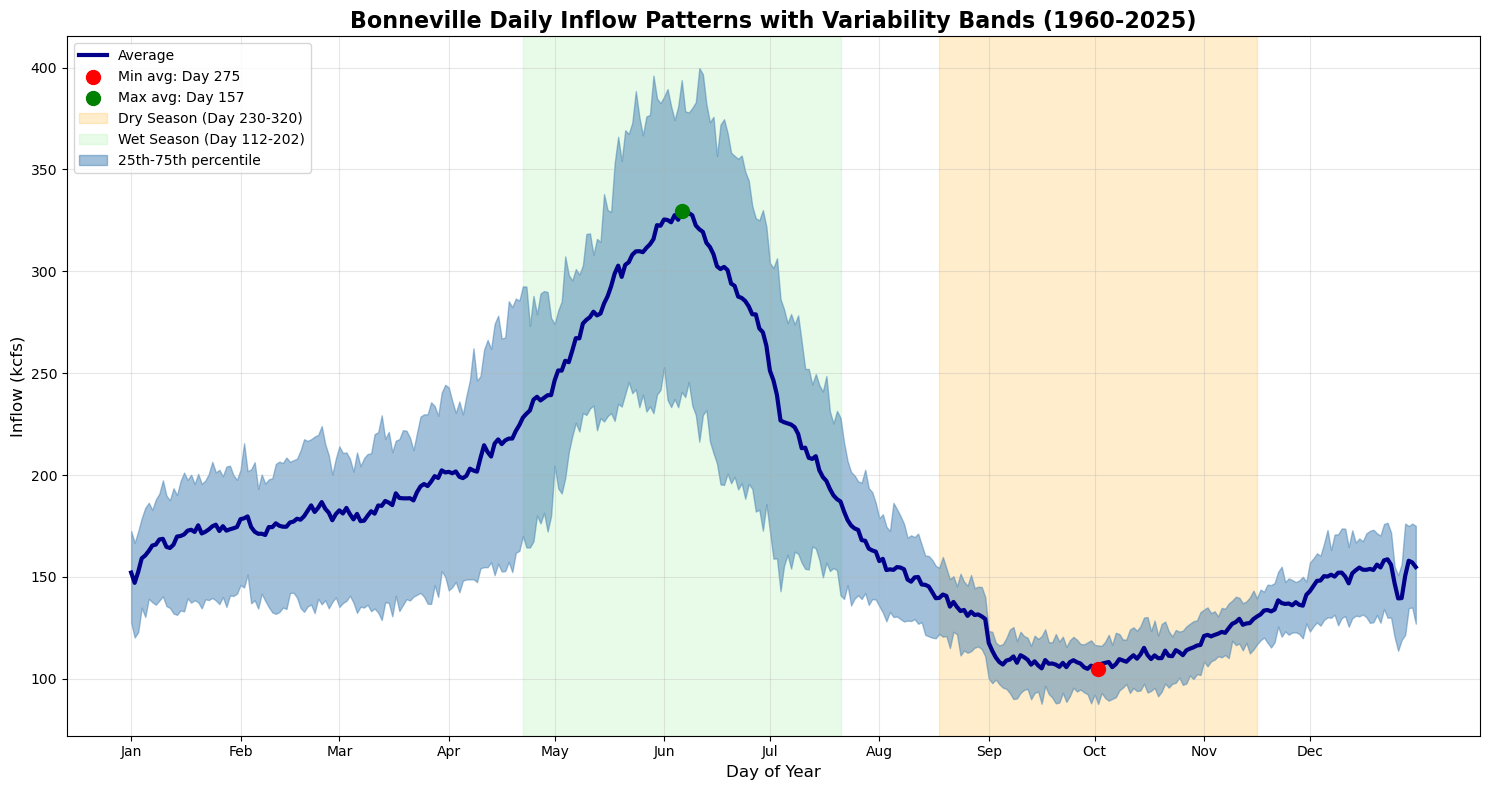

In [51]:
# Create date labels for x-axis (using 2023 as reference year)
def create_date_labels():
    dates = []
    date_labels = []
    base_date = datetime(2023, 1, 1)
    
    for day in range(1, 366):  # Days 1-365
        current_date = base_date + timedelta(days=day - 1)
        dates.append(day)
        date_labels.append(current_date)
    
    return dates, date_labels

days, date_labels = create_date_labels()


# Alternative: More detailed plot with confidence intervals
def plot_with_percentiles():

    month_starts = [1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]  # Approximate month starts
    month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    """Plot with percentile bands showing variability"""
    
    plt.figure(figsize=(15, 8))
    
    # Calculate percentiles for each day (excluding the average row)
    original_data = inflow_matrix_with_avg.iloc[:-1]  # Exclude 'Average' row
    p25 = original_data.quantile(0.25, axis=0)
    p75 = original_data.quantile(0.75, axis=0)
    p10 = original_data.quantile(0.10, axis=0)
    p90 = original_data.quantile(0.90, axis=0)
    
    # Plot average line
    plt.plot(days, daily_averages.values, linewidth=3, color='darkblue', label='Average')
    
    # Highlight extremes
    plt.scatter([min_day], [min_value], color='red', s=100, zorder=5, label=f'Min avg: Day {min_day}')
    plt.scatter([max_day], [max_value], color='green', s=100, zorder=5, label=f'Max avg: Day {max_day}')

    # Add shaded regions for wet and dry seasons
    if dry_start > dry_end:  # Wraps around year
        plt.axvspan(dry_start, 365, alpha=0.2, color='orange', label=f'Dry Season (Day {dry_start}-365, 1-{dry_end})')
        plt.axvspan(1, dry_end, alpha=0.2, color='orange')
    else:
        plt.axvspan(dry_start, dry_end, alpha=0.2, color='orange', label=f'Dry Season (Day {dry_start}-{dry_end})')
    
    if wet_start > wet_end:  # Wraps around year
        plt.axvspan(wet_start, 365, alpha=0.2, color='lightgreen', label=f'Wet Season (Day {wet_start}-365, 1-{wet_end})')
        plt.axvspan(1, wet_end, alpha=0.2, color='lightgreen')
    else:
        plt.axvspan(wet_start, wet_end, alpha=0.2, color='lightgreen', label=f'Wet Season (Day {wet_start}-{wet_end})')

    # Plot percentile bands
    # plt.fill_between(days, p10.values, p90.values, alpha=0.2, color='lightblue', label='10th-90th percentile')
    plt.fill_between(days, p25.values, p75.values, alpha=0.5, color='steelblue', label='25th-75th percentile')
    
        
    plt.title('Bonneville Daily Inflow Patterns with Variability Bands (1960-2025)', fontsize=16, fontweight='bold')
    plt.xlabel('Day of Year', fontsize=12)
    plt.ylabel('Inflow (kcfs)', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.xticks(month_starts, month_labels)
    plt.tight_layout()
    plt.show()

plot_with_percentiles()

## AR Time Series Data Load

In [54]:
## Load Bonneville Data
# Manually fixing timezone (from PST)

bon = pd.read_csv(bon_path + "bon-fullflow.csv")
# bon = pd.read_excel(bon_path + "bon-inflow-calc.xlsx")
bon['Date Time'] = pd.to_datetime(bon['Date Time'])
bon['Date Time'] = bon['Date Time'] + pd.Timedelta(hours=4)

In [56]:
bon.head()

,Date Time,BON.Flow-Gen.Ave.1Hour.1Hour.CBT-REV [kcfs],BON.Flow-In.Inst.~6Hours.0.RFC-FCST [kcfs],BON.Flow-Out.Ave.1Hour.1Hour.CBT-REV [kcfs],BON.Flow-Spill.Ave.1Hour.1Hour.CBT-REV [kcfs]
0,2018-01-01 00:00:00,170.3,NaN,173.8,0.0
1,2018-01-01 01:00:00,171.6,NaN,175.1,0.0
2,2018-01-01 02:00:00,172.2,NaN,175.7,0.0
3,2018-01-01 03:00:00,171.5,NaN,175.0,0.0
4,2018-01-01 04:00:00,172.3,NaN,175.8,0.0


In [58]:
## Load Dalles Data
# Manually fixing timezone (from PST)

tda = pd.read_csv(tda_path + "tda-fullflow.csv")
tda['Date Time'] = pd.to_datetime(tda['Date Time'])
tda['Date Time'] = tda['Date Time'] + pd.Timedelta(hours=4)

In [60]:
tda.head()

,Date Time,TDA.Flow-Gen.Ave.1Hour.1Hour.CBT-REV [kcfs],TDA.Flow-In.Inst.~6Hours.0.RFC-FCST [kcfs],TDA.Flow-Out.Ave.1Hour.1Hour.CBT-REV [kcfs],TDA.Flow-Spill.Ave.1Hour.1Hour.CBT-REV [kcfs]
0,2018-01-01 00:00:00,162.6,NaN,163.7,0.0
1,2018-01-01 01:00:00,161.9,NaN,162.9,0.0
2,2018-01-01 02:00:00,163.6,NaN,164.7,0.0
3,2018-01-01 03:00:00,161.9,NaN,162.9,0.0
4,2018-01-01 04:00:00,148.4,NaN,149.4,0.0


## Merge Datasets

In [63]:
inflow_col = "BON.Flow-In.Inst.~6Hours.0.RFC-FCST [kcfs]"
# inflow_col = "Calculated Hourly Inflow [kcfs]" 
outflow_col = "TDA.Flow-Out.Ave.1Hour.1Hour.CBT-REV [kcfs]"

In [65]:
# Gather Bonneville 6-Hr inflow and convert to m3/hr
flow = bon[["Date Time", inflow_col]].dropna().rename(columns={inflow_col: "inflow_kcfs"})
flow['inflow_m3hr'] = flow['inflow_kcfs'].apply(lambda x: kcfs_to_m3hr(x))

# Merge in with Dalles total outflow data 
flow = flow.merge(tda[["Date Time", outflow_col]], how='inner', on='Date Time').rename(columns={outflow_col: "outflow_kcfs"})
flow['outflow_m3hr'] = flow['outflow_kcfs'].apply(lambda x: kcfs_to_m3hr(x))

# Drop kcfs columns
flow = flow.drop(['inflow_kcfs', 'outflow_kcfs'], axis=1)

In [67]:
# flow['inflow_m3hr'] = replace_outliers(flow['inflow_m3hr'])

In [69]:
flow.head()

,Date Time,inflow_m3hr,outflow_m3hr
0,2018-01-05 02:00:00,1.881769e+07,18371750.4
1,2018-01-05 08:00:00,1.868770e+07,9940320.0
2,2018-01-05 14:00:00,1.891240e+07,21165235.2
3,2018-01-05 20:00:00,1.906584e+07,19656345.6
4,2018-01-06 02:00:00,1.879455e+07,19381075.2


## Extract Seasonal Datasets

In [72]:
# Remove 2025 data (ncomplete seasons)
flow = flow[flow["Date Time"].dt.year < 2025]

# Create DoY column
doy = flow["Date Time"].dt.dayofyear

# Wet season mask
wet_mask = (doy >= wet_start) & (doy <= wet_end)

# Dry season mask
dry_mask = (doy >= dry_start) & (doy <= dry_end)

# Build the dataframes
wet_flow = flow[wet_mask].copy()
dry_flow = flow[dry_mask].copy()

In [88]:
# Visualize Flow Datasets

def plot_flow(df, tick_stride, season):
    plt.figure(figsize=(12, 4))
    
    # convert to strings for categorical x-axis
    x = df['Date Time'].dt.strftime("%Y-%m-%d")
    
    # plt.plot(x, df['outflow_m3hr'], label="TDA Outflow")
    plt.plot(x, df['inflow_m3hr'], label="BON Inflow")
    
    plt.title(f"{season} Season System Inflow", fontsize = 16)
    plt.ylabel('Flow [m³/hr]')
    plt.legend()
    
    # control tick density: show only every nth label
    plt.xticks(x[::tick_stride], rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()


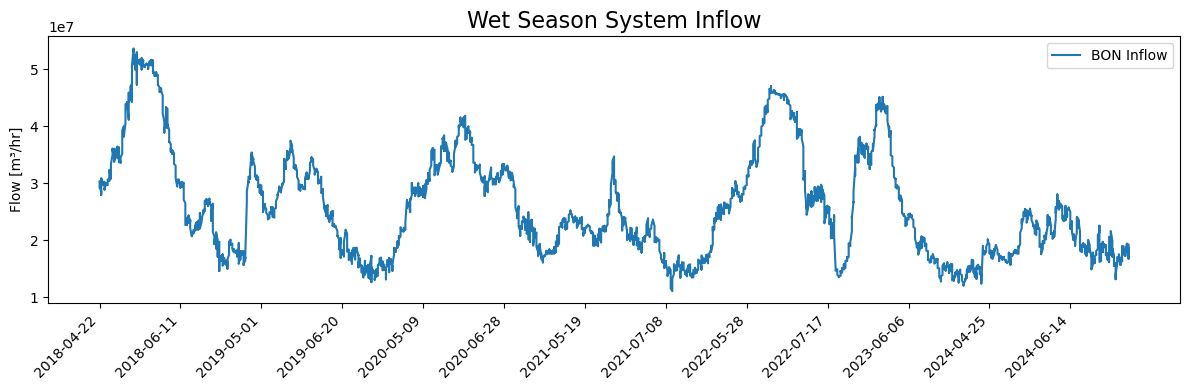

In [90]:
plot_flow(wet_flow, 200, "Wet")

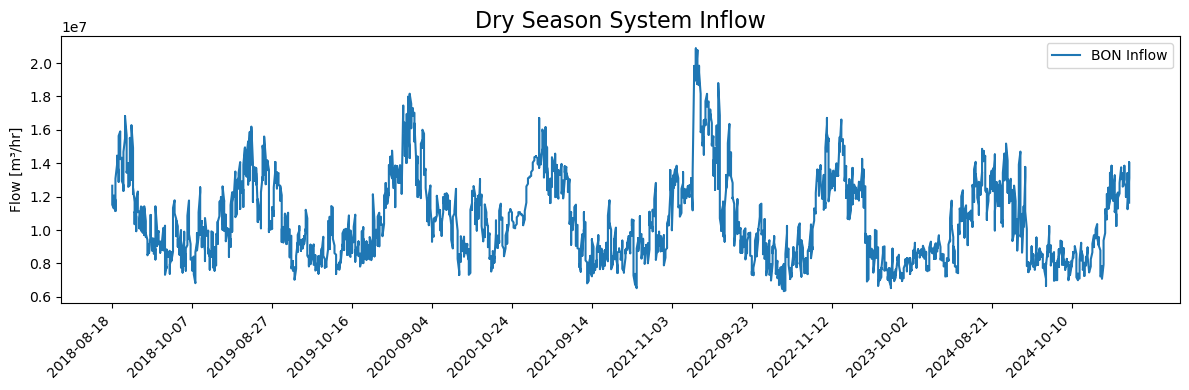

In [92]:
plot_flow(dry_flow, 200, "Dry")

# Seasonal OLS Models

## Preprocessing

### Normalize Data (Z-Score)

In [97]:
## Wet Season

wet_scaler = StandardScaler() # removes mean and converts to unit variance for each column
wet_flow_norm = wet_scaler.fit_transform(wet_flow.copy().drop(['Date Time'], axis=1))
wet_flow_norm = pd.DataFrame(wet_flow_norm, columns=wet_flow.columns[1:])

In [99]:
print(f"{'Feature':<20} {'Mean':>12} {'Std Dev':>12} {'Variance':>12}")
print("-" * 58)
for i, col in enumerate(wet_flow.columns[1:]):
    print(f"{col:<20} {wet_scaler.mean_[i]:>12.2e} {wet_scaler.scale_[i]:>12.2e} {wet_scaler.var_[i]:>12.2e}")

Feature                      Mean      Std Dev     Variance
----------------------------------------------------------
inflow_m3hr              2.58e+07     9.21e+06     8.49e+13
outflow_m3hr             2.37e+07     9.12e+06     8.32e+13


In [101]:
## Dry Season

dry_scaler = StandardScaler() # removes mean and converts to unit variance for each column
dry_flow_norm = dry_scaler.fit_transform(dry_flow.copy().drop(['Date Time'], axis=1))
dry_flow_norm = pd.DataFrame(dry_flow_norm, columns=dry_flow.columns[1:])

In [103]:
print(f"{'Feature':<20} {'Mean':>12} {'Std Dev':>12} {'Variance':>12}")
print("-" * 58)
for i, col in enumerate(dry_flow.columns[1:]):
    print(f"{col:<20} {dry_scaler.mean_[i]:>12.2e} {dry_scaler.scale_[i]:>12.2e} {dry_scaler.var_[i]:>12.2e}")

Feature                      Mean      Std Dev     Variance
----------------------------------------------------------
inflow_m3hr              1.06e+07     2.47e+06     6.10e+12
outflow_m3hr             9.69e+06     2.79e+06     7.80e+12


### Lag Features

In [112]:
p = 4 + 1
up_feat = False
down_feat = True 
x_col_name = 'outflow_m3hr'
y_col_name = 'inflow_m3hr'

In [114]:
## Wet Season

wet_flow_lag, feature_cols = preproc.create_lag_features_colname(wet_flow_norm.copy(), p, x_col_name, y_col_name, up_feat, down_feat)

# Add back in Date Time as index
wet_flow_lag.index = wet_flow["Date Time"]

# Drop rows with NaN values resulting from creating lag features
wet_flow_lag.dropna(inplace=True)

In [116]:
wet_flow_lag.head()

,inflow_m3hr,outflow_m3hr,inflow_m3hr_Lag_1,inflow_m3hr_Lag_2,inflow_m3hr_Lag_3,inflow_m3hr_Lag_4
Date Time,,,,,,
2018-04-23 02:00:00,0.314129,0.284386,0.368393,0.472174,0.428079,0.494493
2018-04-23 08:00:00,0.283256,0.083247,0.314129,0.368393,0.472174,0.428079
2018-04-23 14:00:00,0.231272,0.494464,0.283256,0.314129,0.368393,0.472174
2018-04-23 20:00:00,0.553028,0.544749,0.231272,0.283256,0.314129,0.368393
2018-04-24 02:00:00,0.476324,0.516813,0.553028,0.231272,0.283256,0.314129


In [118]:
## Dry Season

dry_flow_lag, feature_cols = preproc.create_lag_features_colname(dry_flow_norm.copy(), p, x_col_name, y_col_name, up_feat, down_feat)

# Add back in Date Time as index
dry_flow_lag.index = dry_flow["Date Time"]

# Drop rows with NaN values resulting from creating lag features
dry_flow_lag.dropna(inplace=True)

In [120]:
dry_flow_lag.head()

,inflow_m3hr,outflow_m3hr,inflow_m3hr_Lag_1,inflow_m3hr_Lag_2,inflow_m3hr_Lag_3,inflow_m3hr_Lag_4
Date Time,,,,,,
2018-08-19 02:00:00,0.291111,0.182363,0.381574,0.642226,0.591607,0.842928
2018-08-19 08:00:00,0.327404,0.182363,0.291111,0.381574,0.642226,0.591607
2018-08-19 14:00:00,0.438675,-0.011127,0.327404,0.291111,0.381574,0.642226
2018-08-19 20:00:00,0.606140,-0.003826,0.438675,0.327404,0.291111,0.381574
2018-08-20 02:00:00,0.496479,0.029031,0.606140,0.438675,0.327404,0.291111


## Train / Test Split

In [123]:
train_start_year = '2018'
test_start_year = '2024'

In [125]:
## Enforce Framework
if framework == "DDU":
    feature_cols = ['inflow_m3hr_Lag_1', 'outflow_m3hr_Lag_1']

if framework == "DIU":
    feature_cols = ['inflow_m3hr_Lag_1'] #, 'inflow_m3hr_Lag_2']

print(feature_cols)

['inflow_m3hr_Lag_1']


In [127]:
## Split the data into training and testing sets

def split_train_test(flow_lag, feature_cols, y_col_name, test_start_year, season):
    # Train/test split
    train_data = flow_lag[flow_lag.index < test_start_year]
    test_data = flow_lag[flow_lag.index >= test_start_year]

    # Features + target
    X_train = train_data[feature_cols]
    y_train = train_data[y_col_name]
    X_test = test_data[feature_cols]
    y_test = test_data[y_col_name]

    # Return dictionary with season-prepended keys
    return {
        f"{season}_train_data": train_data,
        f"{season}_test_data": test_data,
        f"{season}_X_train": X_train,
        f"{season}_y_train": y_train,
        f"{season}_X_test": X_test,
        f"{season}_y_test": y_test,
    }

In [129]:
wet_splits = split_train_test(wet_flow_lag, feature_cols, y_col_name, test_start_year, "wet")
dry_splits = split_train_test(dry_flow_lag, feature_cols, y_col_name, test_start_year, "dry")

In [131]:
wet_splits["wet_X_train"].head()

,inflow_m3hr_Lag_1
Date Time,
2018-04-23 02:00:00,0.368393
2018-04-23 08:00:00,0.314129
2018-04-23 14:00:00,0.283256
2018-04-23 20:00:00,0.231272
2018-04-24 02:00:00,0.553028


## Wet Season OLS Model

In [134]:
# Step 1: Add constant (intercept)
wet_X_train_const = sm.add_constant(wet_splits["wet_X_train"])

# Step 2: Fit OLS model
wet_model = sm.OLS(wet_splits["wet_y_train"], wet_X_train_const).fit(cov_type='HC1') # Heteroskedasticity-consistent

# Step 3: View summary
print(wet_model.summary())

                            OLS Regression Results                            
Dep. Variable:            inflow_m3hr   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 1.979e+05
Date:                Tue, 27 Jan 2026   Prob (F-statistic):               0.00
Time:                        11:34:19   Log-Likelihood:                 1836.4
No. Observations:                2179   AIC:                            -3669.
Df Residuals:                    2177   BIC:                            -3657.
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0004      0.00

In [136]:
# Extract coefficients and p-values into a tidy DataFrame
coef_df = pd.DataFrame({
    'feature': wet_model.params.index,
    'coefficient': wet_model.params.values
    #'p_value': model.pvalues.values,
    #'t_value': model.tvalues.values
})

# Optional: sort by absolute coefficient size
coef_df = coef_df.reindex(coef_df['coefficient'].abs().sort_values(ascending=False).index)

print(coef_df)

             feature  coefficient
1  inflow_m3hr_Lag_1     0.995421
0              const    -0.000354


In [138]:
wet_residuals = wet_model.resid
wet_fitted_vals = wet_model.fittedvalues

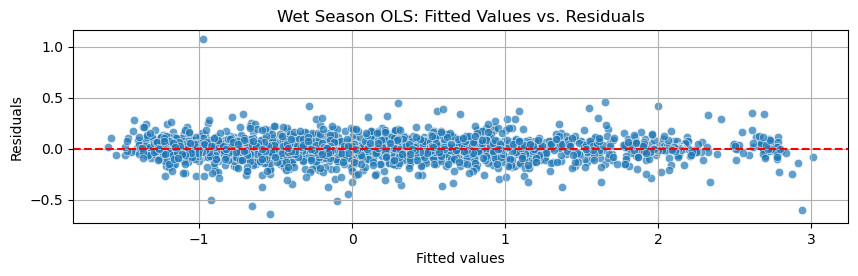

In [140]:
# Checking for Heteroskedasticity

preproc.plot_variance("Wet Season OLS", wet_fitted_vals, wet_residuals, bounds=False)

In [142]:
# Display Equation

params = wet_model.params
latex_eq = f"\\hat{{y}} = {params.iloc[0]:.4f}"
for coef, feature in zip(params.iloc[1:], feature_cols):
    sign = "+" if coef >= 0 else "-"
    coef_abs = abs(coef)
    clean_feature = clean_variable_name(feature)
    latex_eq += f" {sign} {coef_abs:.3f} {clean_feature}"

In [144]:
display(Math(latex_eq))

<IPython.core.display.Math object>

### Evaluation

In [147]:
wet_X_test_const = sm.add_constant(wet_splits["wet_X_test"])  # Add intercept term
wet_X_test_const['const'] = np.ones(len(wet_splits["wet_X_test"]))
wet_X_test_const = pd.DataFrame(wet_X_test_const, columns=wet_model.model.exog_names)
wet_y_pred = wet_model.predict(wet_X_test_const)

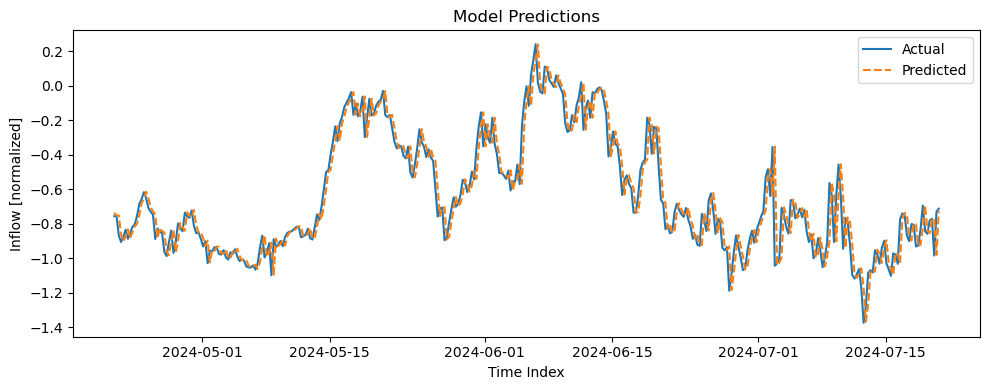

In [149]:
# Dropping the first predicted value since not enough lag info

preproc.plot_inflow_forecasts(wet_splits["wet_y_test"].iloc[1:], wet_y_pred.iloc[1:])

In [151]:
# Calculate model performance without the first predicted value

preproc.print_test_stats(wet_splits["wet_y_test"].iloc[1:], wet_y_pred.iloc[1:])

RMSE: 0.105
MAE: 0.075
R²: 0.900


### Residuals

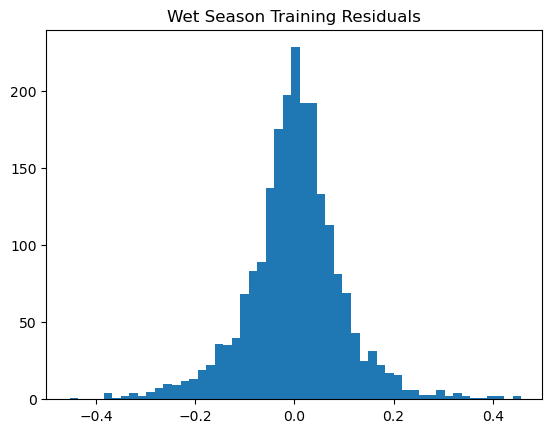

In [154]:
plt.hist(wet_residuals, bins = 100)
plt.title('Wet Season Training Residuals')
plt.xlim([-.5, .5])
plt.show()

In [156]:
mean = wet_residuals.mean()
std = wet_residuals.std()
(round(mean,3), round(std, 4))

(0.0, 0.1042)

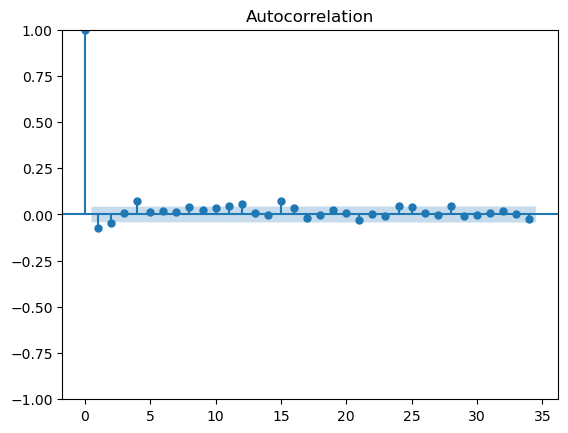

In [158]:
plot_acf(wet_residuals)
plt.show()

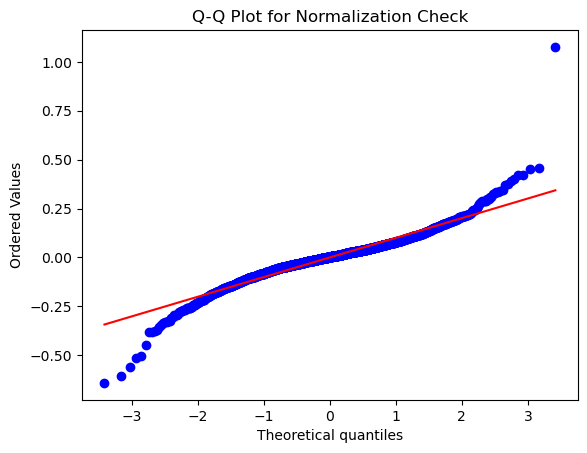

In [160]:
stats.probplot(wet_residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot for Normalization Check")
plt.show()

### Data Export

In [74]:
if framework == "DDU":
    wet_data_to_save = {
        "data": wet_splits,
        "y_pred": wet_y_pred,
        "residuals": wet_residuals,
    }

    # Save to pickle
    with open("wet_ols_model.pkl", "wb") as f:
        pickle.dump(wet_data_to_save, f)

    print("Saved")

Saved


## Dry Season OLS Model

In [163]:
# Step 1: Add constant (intercept)
dry_X_train_const = sm.add_constant(dry_splits["dry_X_train"])

# Step 2: Fit OLS model
dry_model = sm.OLS(dry_splits["dry_y_train"], dry_X_train_const).fit(cov_type='HC1') # Heteroskedasticity-consistent

# Step 3: View summary
print(dry_model.summary())

                            OLS Regression Results                            
Dep. Variable:            inflow_m3hr   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                 1.645e+04
Date:                Tue, 27 Jan 2026   Prob (F-statistic):               0.00
Time:                        11:34:50   Log-Likelihood:                -597.40
No. Observations:                2174   AIC:                             1199.
Df Residuals:                    2172   BIC:                             1210.
Df Model:                           1                                         
Covariance Type:                  HC1                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0025      0.00

In [165]:
# Extract coefficients and p-values into a tidy DataFrame
coef_df = pd.DataFrame({
    'feature': dry_model.params.index,
    'coefficient': dry_model.params.values
    #'p_value': model.pvalues.values,
    #'t_value': model.tvalues.values
})

# Optional: sort by absolute coefficient size
coef_df = coef_df.reindex(coef_df['coefficient'].abs().sort_values(ascending=False).index)

print(coef_df)

             feature  coefficient
1  inflow_m3hr_Lag_1     0.950187
0              const     0.002509


In [167]:
dry_residuals = dry_model.resid
dry_fitted_vals = dry_model.fittedvalues

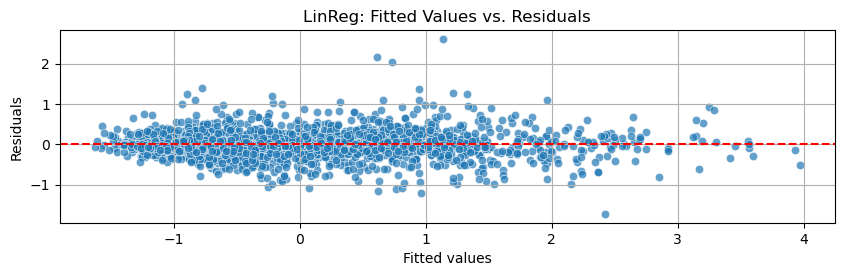

In [169]:
# Checking for Heteroskedasticity

preproc.plot_variance("LinReg", dry_fitted_vals, dry_residuals, bounds=False)

In [171]:
# Display Equation

params = dry_model.params
latex_eq = f"\\hat{{y}} = {params.iloc[0]:.4f}"
for coef, feature in zip(params.iloc[1:], feature_cols):
    sign = "+" if coef >= 0 else "-"
    coef_abs = abs(coef)
    clean_feature = clean_variable_name(feature)
    latex_eq += f" {sign} {coef_abs:.3f} {clean_feature}"

In [173]:
display(Math(latex_eq))

<IPython.core.display.Math object>

### Evaluation

In [176]:
dry_X_test_const = sm.add_constant(dry_splits["dry_X_test"])  # Add intercept term
dry_X_test_const['const'] = np.ones(len(dry_splits["dry_X_test"]))
dry_X_test_const = pd.DataFrame(dry_X_test_const, columns=dry_model.model.exog_names)
dry_y_pred = wet_model.predict(dry_X_test_const)

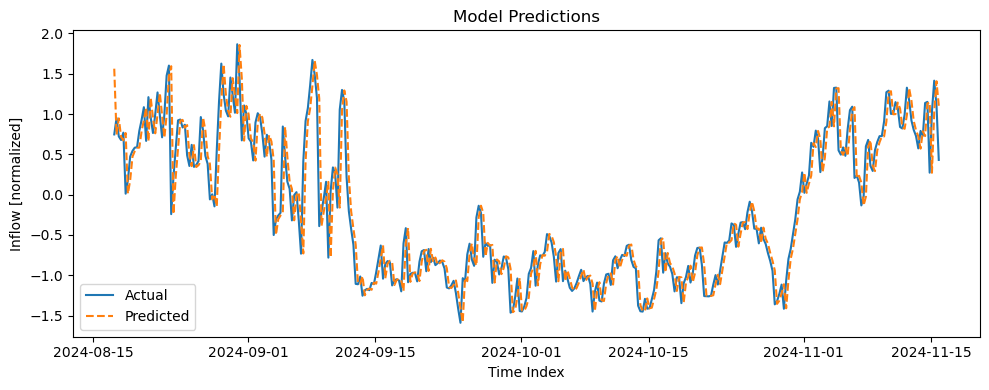

In [178]:
# Dropping the first predicted value since not enough lag info

preproc.plot_inflow_forecasts(dry_splits["dry_y_test"].iloc[1:], dry_y_pred.iloc[1:])

In [180]:
# Calculate model performance without the first predicted value

preproc.print_test_stats(dry_splits["dry_y_test"].iloc[1:], dry_y_pred.iloc[1:])

RMSE: 0.322
MAE: 0.221
R²: 0.866


### Residuals

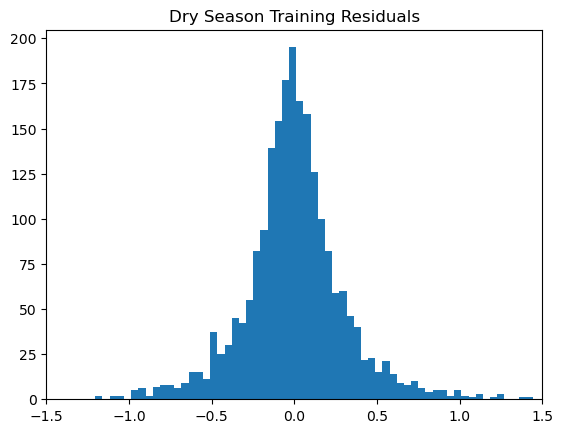

In [183]:
plt.hist(dry_residuals, bins = 100)
plt.title('Dry Season Training Residuals')
plt.xlim([-1.5, 1.5])
plt.show()

In [185]:
mean = dry_residuals.mean()
std = dry_residuals.std()
(round(mean,3), round(std, 4))

(-0.0, 0.3186)

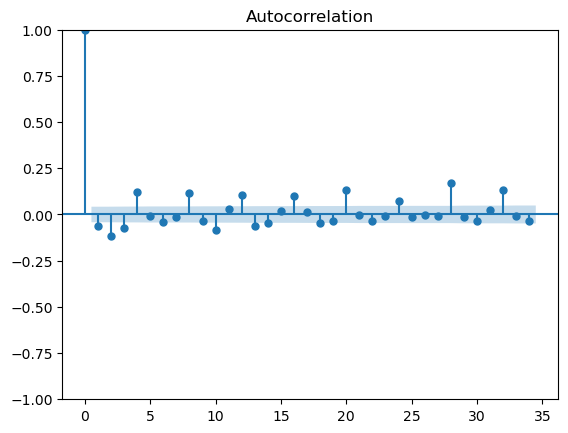

In [187]:
plot_acf(dry_residuals)
plt.show()

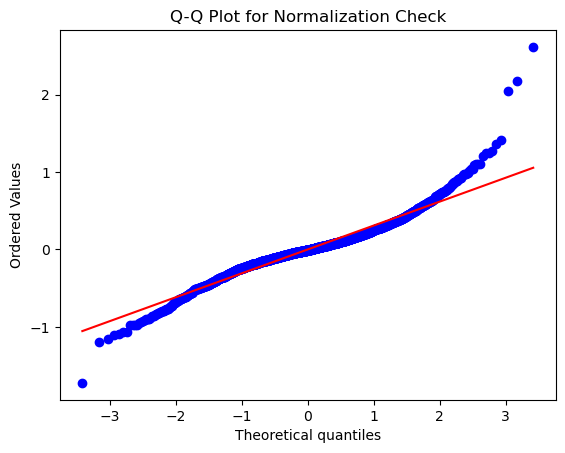

In [189]:
stats.probplot(dry_residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot for Normalization Check")
plt.show()

In [191]:
# plt.scatter(dry_splits["dry_y_train"], dry_residuals)
# plot moving window mean and you will see a bit of structure
# a nonlinear model (nearest neighbor or neural net will go away)

In [193]:
if framework == "DDU":
    dry_data_to_save = {
        "data": dry_splits,
        "y_pred": dry_y_pred,
        "residuals": dry_residuals,
    }

    # Save to pickle
    with open("dry_ols_model.pkl", "wb") as f:
        pickle.dump(dry_data_to_save, f)

    print("Saved")